### Initial Setup

In [1]:
# Install
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install scikit-learn

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Import
import os 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile 
from skimage import io 
from torch.utils.data import Dataset
import torch 
import pandas as pd 
from torchvision import transforms
import copy
from sklearn.metrics import mean_squared_error

In [3]:
# System Check
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

In [4]:
# Find GPU
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [5]:
# Reserve GPU
if IN_CADE:
    define_gpu_to_use()

Chosen GPU: 0


### Load and Visualize Dataset

In [6]:
# Opens zip file and places data in datsets folder
def open_zip(filename):
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()

In [7]:
# Return indexes to split data by for train, val, and test
# Splits are 70% train, 10% val, 20% test
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [8]:
# Dataset class for Truss (Bracket/Beam) dataset
class TrussDataset(Dataset):
    def __init__(self, csv_file, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        # Get the split
        all_attributes_frame = pd.read_csv(root_dir + csv_file)
        ids = get_split(pd.unique(all_attributes_frame['ID']), split)
        self.attributes_frame = all_attributes_frame[all_attributes_frame['ID'].isin(ids)]
              
    def __len__(self):
        return len(self.attributes_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.attributes_frame.iloc[idx, 1])
        image = io.imread(image_name)
        image = image.astype(np.float32)
        image = image[:,:,:3]
        image = image/255
        image = np.swapaxes(image, 0, 1)
        image = np.swapaxes(image, 0, 2)
        attributes = self.attributes_frame.iloc[idx, 2:].values
        attributes = attributes.astype('float')
        attribute_names = self.attributes_frame.columns[2:].values
        return torch.FloatTensor(image), torch.FloatTensor(attributes), list(attribute_names)

In [9]:
# Open zip of dataset
open_zip('trussData.zip')

In [10]:
# Create train, val, and test datasets
train_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/')
val_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='val')
test_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='test')

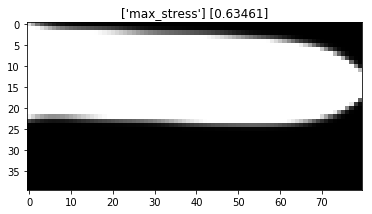

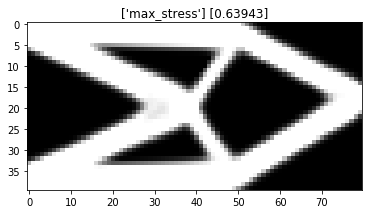

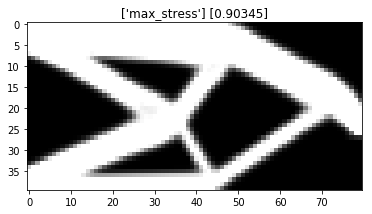

In [11]:
# Visualing a few cases of the training set
for batch_idx, (image, attribute, name) in enumerate(train_dataset):
    if batch_idx%250 == 0: 
        plt.figure()
        plt.title(str(name) + ' ' + str(attribute.cpu().numpy()))
        plt.imshow(image[:,:,:].permute([1, 2, 0]).cpu().numpy())

In [12]:
# Calculates L2 for images and MSE for regression - want both close to 0
def get_score_model(model, data_loader):
    model.eval()
    
    with torch.no_grad():
        distances = []
        mse = []
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, logvar, reg = model(image)
            # Reconstruction Score
            euclidean_dist = torch.pow(torch.sum(torch.pow((image - recon), 2)), 0.5)
            distances.append(euclidean_dist.cpu().numpy())
            # Regression Score
            y_true = attribute.cpu().numpy()
            y_pred = reg.cpu().numpy()         
            mse.append(mean_squared_error(y_true, y_pred))
    
    return np.mean(distances), np.mean(mse)

In [13]:
# Classes to create VAE, ability to change kernel_size of filters for convolution layers
# and the latent representation dim
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        padding = int((kernel_size - 1) / 2)
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.batch = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

class TransBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransBlock, self).__init__()
        self.convT = torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.convT(x)
        return x

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 32, 5, 10) # see if there is a way to not have this hardcoded

In [14]:
# VAE with Regression - The reconstruction and regression are done from the
# latent variables calculated from the reparametrization (distribution)
class VAE_REG(torch.nn.Module):
    def __init__(self, kernel_size, z_dim):
        super(VAE_REG, self).__init__()
        self.encoder = torch.nn.Sequential(
        ConvBlock(in_channels=3, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=8, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=16, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        Flatten()) 
        
        self.mu = torch.nn.Linear(1600, z_dim)
        self.logvar = torch.nn.Linear(1600, z_dim)
        self.fc = torch.nn.Linear(z_dim, 1600)
        
        self.decoder = torch.nn.Sequential(
        UnFlatten(),
        TransBlock(in_channels=32, out_channels=32),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=16, kernel_size=kernel_size),
        TransBlock(in_channels=16, out_channels=16),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=8, kernel_size=kernel_size),
        TransBlock(in_channels=8, out_channels=8),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=3, kernel_size=kernel_size))
        
        self.regression = torch.nn.Sequential(
            torch.nn.Linear(in_features=z_dim, out_features=4),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=4, out_features=1))
            
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.cuda.FloatTensor(mu.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, x):
        mu, logvar = self.mu(x), self.logvar(x)
        z = self.reparametrize(mu, logvar)
        return z, mu, logvar
    
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]
    
    def forward(self, x):
        x = self.encoder(x)
        z, mu, logvar = self.bottleneck(x) # z is latent representation
        x = self.fc(z)
        x = torch.sigmoid(self.decoder(x)) # VAE output
        r = self.regression(z) # Regression output
        return x, mu, logvar, r

In [15]:
# Loss function for this task, combines reconstruction and KL for the image task and the MSELoss
# for the regression task
def loss_function(reconstruction, image, mu, logvar, attributes, r, batch_size):
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(reconstruction, image)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /=  batch_size * image.shape[1] * image.shape[2] * image.shape[3]
    reg_loss =  torch.nn.MSELoss()
    return reconstruction_loss, kl_loss, reg_loss(attributes, r)

In [16]:
# VAE conv kernel size = 3 z_dim=2
BATCH_SIZE = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_loader_score = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#instantiate your model here:
model = VAE_REG(kernel_size=3, z_dim=2)
model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200
# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

train_recon_scores = []
train_r2_scores = []
val_recon_scores = []
val_r2_scores = []
target_score = 35.5 # Want score to be less than this
best_score = 50
best_model = copy.deepcopy(model)

print('Starting Training!')
for epoch in range(n_epochs):
    print('\nEpoch: ' + str(epoch))
    scheduler.step()
    
    model.train()
    
    total_losses = []
    reconstruction_losses = []
    kl_losses = []
    reg_losses = []
    for image, attribute, name in train_loader:
        optimizer.zero_grad()
        image = image.cuda()
        attribute = attribute.cuda()
        recon, mu, logvar, reg = model(image)
        reconstruction_loss, kl_loss, reg_loss = loss_function(recon, image, mu, logvar, attribute, reg, BATCH_SIZE)
        loss = reconstruction_loss + kl_loss + reg_loss
        loss.backward()
        optimizer.step()
        
        total_losses.append(loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        kl_losses.append(kl_loss.item())
        reg_losses.append(reg_loss.item())
        
    print('Total Loss: ' + str(np.mean(total_losses)))
    print('Reconstruction Loss: ' + str(np.mean(reconstruction_losses)))
    print('KL Loss: ' + str(np.mean(kl_losses)))
    print('Regression Loss: ' + str(np.mean(reg_losses)))
    
    # Get training data accuracy
    train_recon_score, train_r2 = get_score_model(model, train_loader_score)
    print('Trainig Reconstruction Score: ' + str(train_recon_score))
    print('Training MSE Score: ' + str(train_r2))
    train_recon_scores.append(train_recon_score)
    train_r2_scores.append(train_r2)
    
    # Get validation data accuracy
    val_recon_score, val_r2 = get_score_model(model, val_loader)
    print('Validation Reconstruction Score: ' + str(val_recon_score))
    print('Validation MSE Score: ' + str(val_r2))
    val_recon_scores.append(val_recon_score)
    val_r2_scores.append(val_r2)
    
    # Save Best Model - Based on Reconstruction Score
    if val_recon_score < target_score and val_recon_score < best_score:
        best_score = val_recon_score
        best_model = copy.deepcopy(model)
        print('New Best Model Saved!')

Starting Training!

Epoch: 0
Total Loss: 0.6978677834783281
Reconstruction Loss: 0.677905889068331
KL Loss: 0.0034245262747130516
Regression Loss: 0.016537369884151432
Trainig Reconstruction Score: 44.18251
Training MSE Score: 0.0046542585
Validation Reconstruction Score: 44.339447
Validation MSE Score: 0.004381868

Epoch: 1
Total Loss: 0.6432692621435437
Reconstruction Loss: 0.6358452081680298
KL Loss: 0.0023093583045660387
Regression Loss: 0.005114695493830368
Trainig Reconstruction Score: 42.160717
Training MSE Score: 0.004826538
Validation Reconstruction Score: 42.434513
Validation MSE Score: 0.0041399566

Epoch: 2
Total Loss: 0.6039528472082956
Reconstruction Loss: 0.5972744226455688
KL Loss: 0.001443039921910635
Regression Loss: 0.005235385056585074
Trainig Reconstruction Score: 40.7272
Training MSE Score: 0.0053610425
Validation Reconstruction Score: 41.131367
Validation MSE Score: 0.0045594424

Epoch: 3
Total Loss: 0.5773659110069275
Reconstruction Loss: 0.5704539401190621
KL L

Trainig Reconstruction Score: 35.349022
Training MSE Score: 0.005345515
Validation Reconstruction Score: 35.67786
Validation MSE Score: 0.004299954

Epoch: 28
Total Loss: 0.46941612362861634
Reconstruction Loss: 0.46261279582977294
KL Loss: 0.00139545391845916
Regression Loss: 0.005407871016567307
Trainig Reconstruction Score: 35.602898
Training MSE Score: 0.005445553
Validation Reconstruction Score: 35.915592
Validation MSE Score: 0.0043615475

Epoch: 29
Total Loss: 0.46794166011469707
Reconstruction Loss: 0.46094696181161066
KL Loss: 0.0013931089363593077
Regression Loss: 0.005601590692198702
Trainig Reconstruction Score: 35.92515
Training MSE Score: 0.0051877424
Validation Reconstruction Score: 36.16109
Validation MSE Score: 0.0043044924

Epoch: 30
Total Loss: 0.4664560198783875
Reconstruction Loss: 0.4596607429640634
KL Loss: 0.0013939946573892875
Regression Loss: 0.005401282540489254
Trainig Reconstruction Score: 35.854652
Training MSE Score: 0.0052630645
Validation Reconstruction

Trainig Reconstruction Score: 35.01692
Training MSE Score: 0.005283393
Validation Reconstruction Score: 35.248547
Validation MSE Score: 0.0047450485

Epoch: 55
Total Loss: 0.449769731930324
Reconstruction Loss: 0.44317349323204586
KL Loss: 0.0013330123753153853
Regression Loss: 0.005263225371683282
Trainig Reconstruction Score: 34.694687
Training MSE Score: 0.005153791
Validation Reconstruction Score: 34.959393
Validation MSE Score: 0.0042334865
New Best Model Saved!

Epoch: 56
Total Loss: 0.44932920123849596
Reconstruction Loss: 0.4427432749952589
KL Loss: 0.0013378633843136153
Regression Loss: 0.005248062360832201
Trainig Reconstruction Score: 34.724323
Training MSE Score: 0.0050777257
Validation Reconstruction Score: 35.10121
Validation MSE Score: 0.0041233203

Epoch: 57
Total Loss: 0.45014836830752236
Reconstruction Loss: 0.4434684919459479
KL Loss: 0.0013204921702189105
Regression Loss: 0.00535938259480255
Trainig Reconstruction Score: 34.774826
Training MSE Score: 0.005223133
Val

Trainig Reconstruction Score: 34.463684
Training MSE Score: 0.0052703135
Validation Reconstruction Score: 34.851784
Validation MSE Score: 0.0039676027

Epoch: 82
Total Loss: 0.4399851586137499
Reconstruction Loss: 0.4334732204675674
KL Loss: 0.0013005719586674657
Regression Loss: 0.005211366012060482
Trainig Reconstruction Score: 34.508152
Training MSE Score: 0.005254386
Validation Reconstruction Score: 34.923912
Validation MSE Score: 0.004629708

Epoch: 83
Total Loss: 0.44232523909636906
Reconstruction Loss: 0.43586068068231854
KL Loss: 0.0013201819516585342
Regression Loss: 0.005144378345825576
Trainig Reconstruction Score: 34.504223
Training MSE Score: 0.005120819
Validation Reconstruction Score: 34.835064
Validation MSE Score: 0.003939664

Epoch: 84
Total Loss: 0.4412105883870806
Reconstruction Loss: 0.43470145251069753
KL Loss: 0.0013102500000968576
Regression Loss: 0.00519888611576919
Trainig Reconstruction Score: 34.401573
Training MSE Score: 0.005357016
Validation Reconstructio

Trainig Reconstruction Score: 34.319057
Training MSE Score: 0.005020268
Validation Reconstruction Score: 34.70344
Validation MSE Score: 0.0039030286

Epoch: 109
Total Loss: 0.43766599382672994
Reconstruction Loss: 0.43118192851543424
KL Loss: 0.0012765302164812705
Regression Loss: 0.005207534249140216
Trainig Reconstruction Score: 34.247257
Training MSE Score: 0.0054902504
Validation Reconstruction Score: 34.754704
Validation MSE Score: 0.005032556

Epoch: 110
Total Loss: 0.4364700675010681
Reconstruction Loss: 0.4300238204853875
KL Loss: 0.0012854219239670783
Regression Loss: 0.005160826152756012
Trainig Reconstruction Score: 34.279995
Training MSE Score: 0.005001016
Validation Reconstruction Score: 34.73981
Validation MSE Score: 0.003951351

Epoch: 111
Total Loss: 0.43520338109561374
Reconstruction Loss: 0.4288699013846261
KL Loss: 0.0012688123928715608
Regression Loss: 0.005064671058374058
Trainig Reconstruction Score: 34.266285
Training MSE Score: 0.005048686
Validation Reconstruct

Trainig Reconstruction Score: 34.342724
Training MSE Score: 0.004976947
Validation Reconstruction Score: 34.94624
Validation MSE Score: 0.0038329277

Epoch: 136
Total Loss: 0.43354655504226686
Reconstruction Loss: 0.4271818816661835
KL Loss: 0.0012676733412912914
Regression Loss: 0.005097000292568867
Trainig Reconstruction Score: 34.15431
Training MSE Score: 0.005008787
Validation Reconstruction Score: 34.65331
Validation MSE Score: 0.0037854167

Epoch: 137
Total Loss: 0.43333880007267
Reconstruction Loss: 0.4270751416683197
KL Loss: 0.0012631578953005373
Regression Loss: 0.005000501282380096
Trainig Reconstruction Score: 34.173843
Training MSE Score: 0.0049557844
Validation Reconstruction Score: 34.713585
Validation MSE Score: 0.0041166134

Epoch: 138
Total Loss: 0.43395647960049766
Reconstruction Loss: 0.42762845797198157
KL Loss: 0.00127277086389118
Regression Loss: 0.005055249261204153
Trainig Reconstruction Score: 34.287148
Training MSE Score: 0.004960898
Validation Reconstruction

Trainig Reconstruction Score: 33.848618
Training MSE Score: 0.0048884465
Validation Reconstruction Score: 34.46212
Validation MSE Score: 0.0038588154

Epoch: 163
Total Loss: 0.42608452822480886
Reconstruction Loss: 0.41992283250604356
KL Loss: 0.0012631600040809384
Regression Loss: 0.00489853580282735
Trainig Reconstruction Score: 33.84207
Training MSE Score: 0.004886435
Validation Reconstruction Score: 34.44933
Validation MSE Score: 0.003940797

Epoch: 164
Total Loss: 0.42613416825022016
Reconstruction Loss: 0.41994799503258295
KL Loss: 0.001264044434563922
Regression Loss: 0.004922129654525114
Trainig Reconstruction Score: 33.85752
Training MSE Score: 0.004884466
Validation Reconstruction Score: 34.507248
Validation MSE Score: 0.003925403

Epoch: 165
Total Loss: 0.4259834332125528
Reconstruction Loss: 0.4198159869228091
KL Loss: 0.0012624405632128141
Regression Loss: 0.004905004124157131
Trainig Reconstruction Score: 33.836613
Training MSE Score: 0.00488492
Validation Reconstruction 

Validation Reconstruction Score: 34.47427
Validation MSE Score: 0.0039227884

Epoch: 190
Total Loss: 0.42549749314785
Reconstruction Loss: 0.41933474583285196
KL Loss: 0.0012731669961275267
Regression Loss: 0.004889581073075533
Trainig Reconstruction Score: 33.821167
Training MSE Score: 0.004868055
Validation Reconstruction Score: 34.450085
Validation MSE Score: 0.0038919894

Epoch: 191
Total Loss: 0.42549958527088166
Reconstruction Loss: 0.4193264641932079
KL Loss: 0.0012724998140973703
Regression Loss: 0.004900621246114107
Trainig Reconstruction Score: 33.81956
Training MSE Score: 0.004892179
Validation Reconstruction Score: 34.440636
Validation MSE Score: 0.0040064063

Epoch: 192
Total Loss: 0.42569934896060396
Reconstruction Loss: 0.4195139208010265
KL Loss: 0.0012741907516361348
Regression Loss: 0.004911238070677167
Trainig Reconstruction Score: 33.821213
Training MSE Score: 0.004883587
Validation Reconstruction Score: 34.438553
Validation MSE Score: 0.0039649527

Epoch: 193
Total

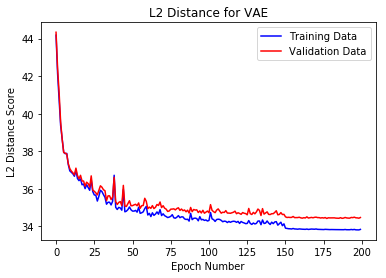

In [17]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_recon_scores, 'b', range(n_epochs), val_recon_scores, 'r')
plt.title('L2 Distance for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('L2 Distance Score')
plt.show()

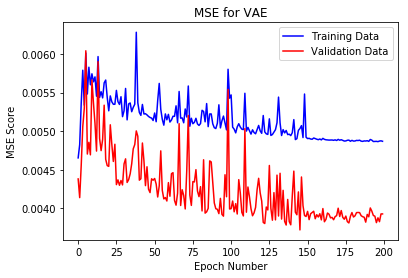

In [18]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_r2_scores, 'b', range(n_epochs), val_r2_scores, 'r')
plt.title('MSE for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('MSE Score')
plt.show()

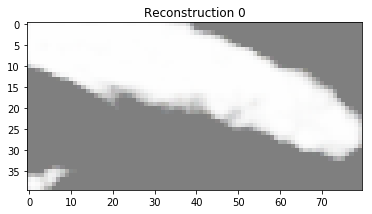

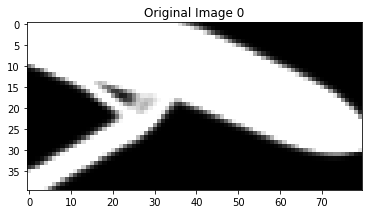

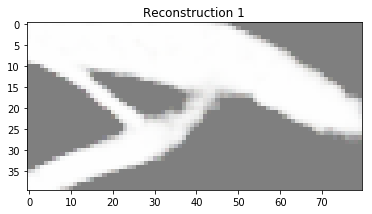

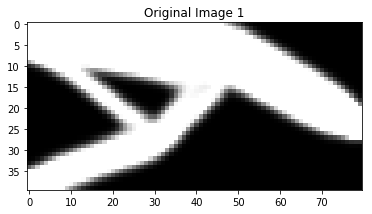

In [19]:
# Show examples of the ground truth image and the reconstruction after
# a pass through the autoencoder
def get_example_outputs(model, data_loader):
    model.eval()
    ground_truth = []
    model_output = []
    with torch.no_grad():
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, var, r = model(image)
            model_output.append(recon)
            ground_truth.append(image)
            if len(model_output) == 2:
                return model_output, ground_truth
            
model_out, gt = get_example_outputs(model, val_loader)
for idx in range(2):
    plt.figure()
    plt.title("Reconstruction " + str(idx))
    model_out[idx] = model_out[idx].view(model_out[idx].shape[1], model_out[idx].shape[2], model_out[idx].shape[3])
    plt.imshow(model_out[idx].permute([1, 2, 0]).cpu().numpy())
    plt.figure()
    plt.title("Original Image " + str(idx))
    gt[idx] = gt[idx].view(gt[idx].shape[1], gt[idx].shape[2], gt[idx].shape[3])
    plt.imshow(gt[idx].permute([1, 2, 0]).cpu().numpy())

In [20]:
test_recon_score, test_mse_score = get_score_model(best_model, test_loader)
print('Test L2 Score: ' + str(test_recon_score))
print('Test MSE Score: ' + str(test_mse_score))

Test L2 Score: 34.307632
Test MSE Score: 0.005217982
